<a href="https://colab.research.google.com/github/chrisdewey/Movie-Recommender-SVD/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
%pip install scikit-surprise
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD, accuracy, Dataset, Reader, dump
from surprise.model_selection import cross_validate, train_test_split
import ipywidgets as widgets
from IPython.display import clear_output, display


%matplotlib inline

     |████████████████████████████████| 11.8 MB 11.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630182 sha256=7eab80031c4cb4ac8f809ab3e973864d88150432d5b9c8b2049821a104ba5ade
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


**Upload CSV files**

In [ ]:
from google.colab import files

print('Upload ratings.csv')
ratings_csv = files.upload()
print('Upload movies.csv')
movies_csv = files.upload()

Upload ratings.csv


**Prepare the data**

In [3]:
# Read and merge the datasets
df_movies = pd.read_csv('/content/movies.csv',
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv('/content/ratings.csv',
                         usecols=['userId', 'movieId', 'rating', 'timestamp'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})  # maybe remove 'timestamp'

df_merged = df_movies.merge(df_ratings, on='movieId')

In [10]:
# TEST DELETE THIS
print(df_movies.head())
print(df_ratings.head())

   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [45]:
avg_movie_rating = df_merged.groupby('title')['rating']\
    .mean().sort_values(ascending=False).reset_index().rename(columns={'rating': 'Avg Rating'})

rating_count = df_merged.groupby('title')['rating']\
    .count().sort_values(ascending=True).reset_index().rename(columns={'rating': 'Rating Count'})

df_incl_rc = df_merged.merge(rating_count, left_on='title', right_on='title', how='left')

rating_count_avg = rating_count.merge(avg_movie_rating, on='title')

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # This was normally COMMENTED OUT?? WHY?? GUESS I DON"T NEED IT? DELETE IF BREAKS> REMOVE COMMENT>


**Exploratory Data Analysis**

In [32]:
import seaborn as sns
# import matplotlib.pyplot as plt  # already imported.... SORT IMPORTS... AND COMMENTS lol
sns.set(font_scale=1)
plt.style.use('dark_background')


Text(0, 0.5, 'Rating Count (Scaled)')

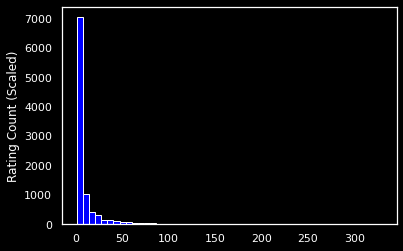

In [51]:
plt.hist(rating_count['Rating Count'], bins=50, color='blue')
plt.ylabel('Rating Count (Scaled)')

In the above histogram, we see that there are many movie which have very few ratings.

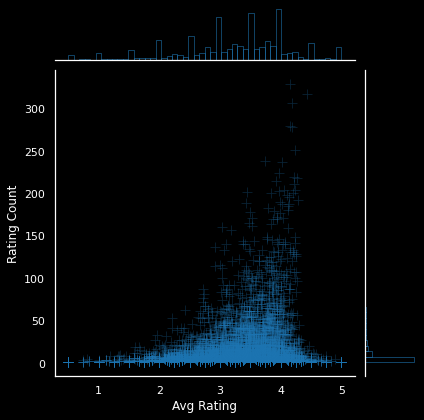

In [59]:
# plt.rcParams["axes.grid"] = False
plot = sns.jointplot(x='Avg Rating', marker='+', y='Rating Count', s=100, marginal_kws=dict(bins=50, fill=False), data=rating_count_avg, alpha=0.3, color='tab:blue')

The above scatterplot shows the relationship between the Average Rating (the x axis) and the Rating Count (the y axis). As we can see, while there are many films with 5 star ratings, virtually none of these have a high rating count. The same holds true for films with extremely low ratings.

To prevent noise in the data which will skew our SVD model, we must establish a usability threshold, whereupon a film, having a high enough rating count, may stay in the dataset for training. Otherwise, the film is removed.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


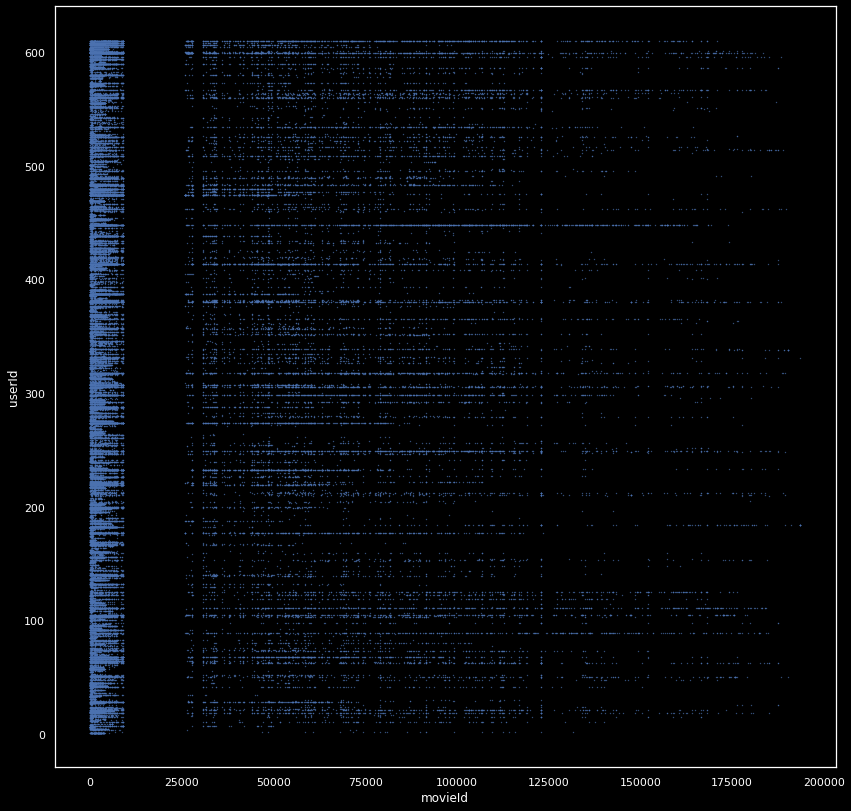

In [98]:
df_merged.plot(x='movieId', y='userId', s=.1, kind='scatter', figsize=(14,14))

**Establish Threshold**

In [ ]:
popularity_threshold = 2
popular_movies = df_incl_rc[df_incl_rc['Rating Count'] >= popularity_threshold]

In [12]:
titles = popular_movies.title.unique().tolist()

# Two dicts for quick look-up later on.
title_dict = df_movies.set_index('title').to_dict()['movieId']
reverse_title_dict = df_movies.set_index('movieId').to_dict()['title']

6278
['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)', 'Sudden Death (1995)', 'GoldenEye (1995)', 'American President, The (1995)', 'Dracula: Dead and Loving It (1995)', 'Balto (1995)', 'Nixon (1995)', 'Cutthroat Island (1995)', 'Casino (1995)', 'Sense and Sensibility (1995)', 'Four Rooms (1995)', 'Ace Ventura: When Nature Calls (1995)', 'Money Train (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Assassins (1995)', 'Powder (1995)', 'Leaving Las Vegas (1995)', 'Othello (1995)', 'Now and Then (1995)', 'Persuasion (1995)', 'City of Lost Children, The (Cité des enfants perdus, La) (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Dangerous Minds (1995)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'It Takes Two (1995)', 'Clueless (1995)', 'Cry, the Beloved Country (1995)', 'Richard III (1995)',

In [13]:
# Format the Dataframe for use in the Scikit Suprise library
df_data = popular_movies.drop(['title', 'timestamp', 'Rating Count'], axis=1)
df_data.rename(columns={'movieId': 'Item', 'userId': 'User', 'rating': 'Rating'}, inplace=True)
df_data.reindex(columns=['User', 'Item', 'Rating'])

,User,Item,Rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
100804,50,188301,3.0
100805,380,188301,4.0
100806,596,188301,4.0
100813,184,189333,4.0


**User Input**

In [14]:
#user input
movie_select = widgets.Combobox(
    placeholder='Choose a Movie',
    options=titles,
    description='Movie_select:',
    ensure_option=True,
    disabled=False
)
rating_select = widgets.FloatSlider(
    value=2.5,
    min=1.0,
    max=5.0,
    step=0.1,
    description='Rating_select:',
    disabled=False,
    coninuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
continue_button = widgets.Button(
    description='Add another film',
    disabled=False,
    button_style='',
    tooltip='Click me'
)
exit_button = widgets.Button(
    description='Done adding films',
    disabled=False,
    button_style='',
    tooltip='Click me',
    wait=True
)
add_button = widgets.Button(
    description='Add movie rating'
)

In [15]:
user_preference = dict()

input_widgets = widgets.HBox([movie_select, rating_select])
dash = widgets.VBox([input_widgets, add_button])

def add_vals(b):
  global user_preference
  id = title_dict[movie_select.value]
  user_preference[id] = rating_select.value
  print('Rating Added.')

add_button.on_click(add_vals)
display(dash)

Rating Added.
Rating Added.
Rating Added.
Rating Added.
Rating Added.
Rating Added.
Rating Added.
Rating Added.


In [16]:
print('Users film ratings:')
user_preference

Users film ratings:


{2335: 2.9,
 8376: 5.0,
 8533: 1.0,
 8641: 5.0,
 51255: 5.0,
 54256: 5.0,
 84772: 5.0,
 107348: 4.6}

In [17]:
user_df = pd.DataFrame(
    {"User": 700, "Item": user_preference.keys(), "Rating": user_preference.values()}
)
df_data = df_data.append(user_df)
df_data

,Item,User,Rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5
...,...,...,...
3,84772,700,5.0
4,2335,700,2.9
5,8641,700,5.0
6,107348,700,4.6


**Train Model**

In [18]:
data = Dataset.load_from_df(df_data, reader=Reader())
training_parameters = {'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.08}

print("Creating trainset:")
trainset = data.build_full_trainset()
print("done.")

start = datetime.now()
print("Training Started:")
from surprise import SVDpp
from surprise.model_selection import train_test_split
# algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])
algo = SVDpp()

# trainset, testset = train_test_split(data, test_size=.25)

algo.fit(trainset)

end = datetime.now()
print("done.\t\t time: ", (end-start).seconds, "seconds")

Creating trainset:
done.
Training Started:
done.		 time:  71 seconds


In [19]:
# DELETE THIS
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8392  0.8459  0.8415  0.8332  0.8421  0.8404  0.0042  
MAE (testset)     0.6440  0.6488  0.6483  0.6396  0.6495  0.6460  0.0037  
Fit time          47.84   47.60   48.67   47.79   48.65   48.11   0.46    
Test time         1.75    1.60    1.88    1.81    2.04    1.82    0.14    


{'fit_time': (47.83752250671387,
  47.59798336029053,
  48.66874313354492,
  47.791701793670654,
  48.64928984642029),
 'test_mae': array([0.64401615, 0.64880592, 0.64826363, 0.63957706, 0.64945023]),
 'test_rmse': array([0.83920599, 0.84587267, 0.84153575, 0.83315874, 0.84209545]),
 'test_time': (1.749105453491211,
  1.603133201599121,
  1.8776421546936035,
  1.811547040939331,
  2.0384669303894043)}

In [ ]:
# Pickle The Model (called dump in Suprise)

In [ ]:
model_file = "/content/trained_model.pickle"
import os
file_name = os.path.expanduser(model_file)
dump.dump(file_name, algo=algo)

In [ ]:
# Load The Model

In [ ]:
def load_model(model_file):
    print (">> Loading dump")
    file_name = os.path.expanduser(model_file)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model

**Predict**

In [ ]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)



In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=5)

for uid, user_ratings in top_n.items():
  x = trainset.to_inner_uid(uid)
  if x == 700:
    print(x, uid, [iid for (iid, _) in user_ratings])
    for rating in user_ratings:
      
      print(reverse_title_dict[rating[0]], end="")
      print(' ', end="")
      print(rating[1])

700 1041 [122, 53, 51, 191, 171]
Boomerang (1992) 5
Lamerica (1994) 5


KeyError: ignored

In [ ]:
model_file = "/content/trained_model.pickle"

user_preds = dict()

def recommend(user):
  uid = user
  #loaded_model = load_model(model_file)
  """
  rating = prediction.est
  details = prediction.details
  uid = prediction.uid
  iid = prediction.iid
  boolval = prediction.r_ui
  """
  s = 0
  # OKAY so try as ints first, then strings. trained on ints instead or smthg?
  for title in titles:
    s += 1
    #print(title)
    movie = title_dict[title]
    #print(movie)
    prediction = algo.predict(uid, movie)
    #global user_preds
    user_preds[title] = prediction.est

  #print(user_preds)
  sorted_user_preds = sorted(user_preds.items(), key=lambda x:-x[1])[:5]
  print(s)
  #print(popular_movies)
  return sorted_user_preds

x = recommend(700)
# x = algo.predict(1, 444, verbose=True)
#print(x.iid)

print('Recommendations:')
for i in range(len(x)):
  print(i+1, end="")
  print('. ', end="")
  print(x[i][0], end="")
  print(', ', end="")
  print("{:.2f}".format(x[i][1]))


6278
Recommendations:
1. Lamerica (1994), 4.91
2. Restoration (1995), 4.70
3. Ruby in Paradise (1993), 4.59
4. Milk Money (1994), 4.58
5. So I Married an Axe Murderer (1993), 4.58
